# Over View (※内容を書き換えてください)
このノートブックでは実験用データセットを使用してfeatureの実験を行います。  
簡単な実験にするためにこのノートブックでは以下の特徴量を比較します。

- FASTD-Standard
- 64-mel filters  

## 学習方法
GMM

　- 学習回数:50回
  - 学習率: 1e-4

## 評価方法
AUC

## データセット
DataSet : 001_HITACHI_fan  
ANR     : 0db  



***
## ノートブックの流れ

1. Set the Parameters  
各パラメーターの設定

2. Import module or package  
モジュールやパッケージのインポート

3. Data load  
wav featureをロードします。

4. Learning  
3層AEで学習します。

5. Predict  
AUCで評価します。

***
## 実験結果

|---|FASTD-Standard|
|:--:|:--:|
|FASTD-Standard|0.6|
|64-mel filters |0.53|


FASTD-Standardのほうが良い精度が出ている。

# Set the Parameters

In [1]:
# data set のパラメーター
dataset = '001_HITACHI_fan'
anr = '0db'
feature_type = 'FASTD_standard'

# 学習のパラメーター
num_epochs = 50
learning_rate = 1e-4

## fastdstdの学習
feature_dim_fastdstd = 34
hidden_dim_fastdstd  = feature_dim_fastdstd//5
latent_dim_fastdstd  = 3


## mfcc64の学習
feature_dim_mfcc64 = 64
hidden_dim_mfcc64  = feature_dim_mfcc64//5
latent_dim_mfcc64  = 3



# Import module or package

In [2]:
import glob
import sys 
from fastprogress import progress_bar
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read
import librosa
from librosa import power_to_db
from librosa.feature.spectral import melspectrogram      

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.mixture import GaussianMixture

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

# Data Load

In [3]:
def wav_dataset_loader(data_set, anr):
    dir_path = '/work-hmcomm/Experiment_DataSet/wav_dataset'
    norm_data_set_path = dir_path +'/'+ data_set +'/'+ anr +'/'+ 'normal/*/*.wav'
    anom_data_set_path = dir_path +'/'+ data_set +'/'+ anr +'/'+ 'abnormal/*/*.wav'
    norm_data_set_list = sorted(glob.glob(norm_data_set_path))
    anom_data_set_list = sorted(glob.glob(anom_data_set_path))
    
    return norm_data_set_list, anom_data_set_list

In [4]:
norm_data_set_list, anom_data_set_list = wav_dataset_loader(dataset, anr)

In [5]:
# 確認
norm_list_head = norm_data_set_list[:5]
anom_list_head = anom_data_set_list[:5]
norm_list_len = len(norm_data_set_list)
anom_list_len = len(anom_data_set_list)

print(f'norm wav file の数 : {norm_list_len}')
display(norm_list_head)
print(f'anom wav file の数 : {anom_list_len}')
display(anom_list_head)

norm wav file の数 : 1011


['/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/normal/ch1/00000000_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/normal/ch1/00000001_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/normal/ch1/00000002_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/normal/ch1/00000003_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/normal/ch1/00000004_ch1.wav']

anom wav file の数 : 407


['/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/abnormal/ch1/00000000_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/abnormal/ch1/00000001_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/abnormal/ch1/00000002_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/abnormal/ch1/00000003_ch1.wav',
 '/work-hmcomm/Experiment_DataSet/wav_dataset/001_HITACHI_fan/0db/abnormal/ch1/00000004_ch1.wav']

## 特徴量のロード

## FAST-D Standardをload

In [6]:
def feature_dataset_loader(data_set,anr, feature_type):
    """
    feature load の関数です。
    
    Parameters
    ---------
    data_set(type:str)
    
    anr(type:str)
    
    feature_type(type:str)
    
    
    Returns
    -------
    norm_train
    anom_train
    norm_test
    anom_test
    
    
    Notes
    -----
    [example]
    データセット：001_HITACHI_fan, ANR : 0db, feature type : FAST-D 標準特徴量 を使用したいとき
    
    
    data_set = '001_HITACHI_fan'
    anr = '0db'
    feature_type = 'FASTD_standard'
    norm_train_0db, anom_train_0db, norm_test_0db, anom_test_0db = feature_loder(data_set, anr, feature_type) 
    
    """
    dir_path = '/work-hmcomm/Experiment_DataSet/feature_dataset'
    feature_path = dir_path +'/'+ data_set +'/'+ anr +'/'+ feature_type +'/csv/*.csv'
    feature_csv_list = sorted(glob.glob(feature_path))
    anom_test, anom_train, norm_test, norm_train = [pd.read_csv(i, index_col=0) for i in feature_csv_list]
    return norm_train, anom_train, norm_test, anom_test

In [7]:
norm_train_0db_fastdstd, anom_train_0db_fastdstd, norm_test_0db_fastdstd, anom_test_0db_fastdstd = feature_dataset_loader(data_set=dataset, anr=anr, feature_type=feature_type)

## mel-spectrogramの抽出

FAST-Dの標準特徴量のtrainとtestを揃える

In [8]:
# wav_nameのリストを作成する
norm_train_0db_list = list(norm_train_0db_fastdstd['wav_name'].unique())
anom_train_0db_list = list(anom_train_0db_fastdstd['wav_name'].unique())
norm_test_0db_list  = list(norm_test_0db_fastdstd['wav_name'].unique())
anom_test_0db_list  = list(anom_test_0db_fastdstd['wav_name'].unique())

In [9]:
def wav2mfcc(wav_list,n_fft, hop_length, n_mfcc):
    """
    wav から　mfccを作成するlibrosaを使って関数
    """
    features_label = ['mfcc'+str(i+1) for i in range(n_mfcc)]
    mfcc_wav_name_df_list = []
    mfcc_df_list = []
    
    for wav in tqdm(wav_list):
        sr, data = read(wav)
        data = np.array(data, dtype='float32')
        S = power_to_db(melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length))
        mfccs = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)

        feat_num = len(mfccs.T)

        wav_name_list = [wav] * feat_num
        
        mfcc_wav_name_df_list.append(pd.DataFrame(wav_name_list, columns=['wav_name']))
        mfcc_df_list.append(pd.DataFrame(mfccs.T, columns=features_label))

    
    mfcc_df = [pd.concat([mfcc_df_list[i], mfcc_wav_name_df_list[i]], axis=1) for i in range(len(mfcc_df_list))]
    
    
    return mfcc_df

In [10]:
n_fft = 1024
hop_length = 512
n_mfcc = 64

norm_train_0db_mfcc64_df = wav2mfcc(wav_list=norm_train_0db_list, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
anom_train_0db_mfcc64_df = wav2mfcc(wav_list=anom_train_0db_list, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
norm_test_0db_mfcc64_df = wav2mfcc(wav_list=norm_test_0db_list, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
anom_test_0db_mfcc64_df = wav2mfcc(wav_list=anom_test_0db_list, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

100%|██████████| 82/82 [00:01<00:00, 41.37it/s]


In [11]:
# dataの数の確認(
print(f'norm_train_0db_wav : {len(norm_train_0db_mfcc64_df)}')
print(f'anom_train_0db_wav : {len(anom_train_0db_mfcc64_df)}')
print(f'norm_test_0db_wav  : {len(norm_test_0db_mfcc64_df)}')
print(f'anom_test_0db_wav  : {len(anom_test_0db_mfcc64_df)}')

norm_train_0db_wav : 809
anom_train_0db_wav : 325
norm_test_0db_wav  : 202
anom_test_0db_wav  : 82


## dataのconcat
wav毎に抽出したDataFrameを一つのDataFrameにします。

In [12]:
# dataのconcat
norm_train_0db_mfcc64 = pd.concat([i for i in norm_train_0db_mfcc64_df])
anom_train_0db_mfcc64 = pd.concat([i for i in anom_train_0db_mfcc64_df])
norm_test_0db_mfcc64 = pd.concat([i for i in norm_test_0db_mfcc64_df])
anom_test_0db_mfcc64 = pd.concat([i for i in anom_test_0db_mfcc64_df])

## datasetの準備

In [13]:
# fast-d standard から不要な列を落とす
drop_list_fastd = ['wav_name', 'target']
norm_train_0db_fastdstd_drop = norm_train_0db_fastdstd.drop(drop_list_fastd, axis=1)
norm_test_0db_fastdstd_drop = norm_test_0db_fastdstd.drop(drop_list_fastd, axis=1)
anom_test_0db_fastdstd_drop = anom_test_0db_fastdstd.drop(drop_list_fastd, axis=1)

In [14]:
# FAST-D 標準特徴量 のsizeの確認
print(f'fast-d standartd train norm size : {norm_train_0db_fastdstd_drop.shape}')
print(f'fast-d standartd test norm size : {norm_test_0db_fastdstd_drop.shape}')
print(f'fast-d standartd test anom size : {anom_test_0db_fastdstd_drop.shape}')

fast-d standartd train norm size : (31551, 34)
fast-d standartd test norm size : (7878, 34)
fast-d standartd test anom size : (3198, 34)


In [15]:
# mfcc64 から不要な列を落とす
drop_list_mfcc64 = ['wav_name']
norm_train_0db_mfcc64_drop = norm_train_0db_mfcc64.drop(drop_list_mfcc64, axis=1)
norm_test_0db_mfcc64_drop  = norm_test_0db_mfcc64.drop(drop_list_mfcc64, axis=1)
anom_test_0db_mfcc64_drop  = anom_test_0db_mfcc64.drop(drop_list_mfcc64, axis=1)

In [16]:
# mfcc64 特徴量 のsizeの確認
print(f'mfcc64 train norm size : {norm_train_0db_mfcc64_drop.shape}')
print(f'mfcc64 test norm size : {norm_test_0db_mfcc64_drop.shape}')
print(f'mfcc64 test anom size : {anom_test_0db_mfcc64_drop.shape}')

mfcc64 train norm size : (253217, 64)
mfcc64 test norm size : (63226, 64)
mfcc64 test anom size : (25666, 64)


# Learning

今回はsklearnのGMMをしようする。 

In [21]:
n_components = 10
covariance_type = 'full'
random_state = 100
gmm_fastdstd = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)
gmm_mfcc64 = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)

In [73]:
class GMMAnomalyDetector:
    def __init__(self, max_n_component, covariance_type='full'):
        self._max_n_component = max_n_component
        self._covariance_type = covariance_type
        self._best_gmm = None
        self.best_n_component = -1

    def fit(self, X):
        # BIC基準でベストなクラスタ数を2～max_n_componentの範囲で探す
        lowest_bic = np.inf
        for n_component in range(2, self._max_n_component + 1):
            gmm = GaussianMixture(n_components=n_component, covariance_type=self._covariance_type)
            gmm.fit(X)
            bic = gmm.bic(X)
            if bic < lowest_bic:
                lowest_bic = bic
                self._best_gmm = gmm
                self.best_n_component = n_component

    def predict(self, X, contamination=0.1):
        # スコア下位N%を異常と見なす
        scores = np.exp(self._best_gmm.score_samples(X))
        ordered_scores = np.argsort(scores)
        anomaly_indices = ordered_scores[:int(len(scores)*contamination + 0.5)]
        # 正常を0、異常を1として返す
        prediction = np.zeros((len(scores)), dtype=np.int)
        prediction[anomaly_indices] = 1
        return scores, prediction

In [74]:
gmm_fasdstd = GMMAnomalyDetector(max_n_component=50)
gmm_mfcc64 = GMMAnomalyDetector(max_n_component=50)

In [75]:
%%time
gmm_fasdstd.fit(norm_train_0db_fastdstd_drop)

CPU times: user 3h 54min 24s, sys: 10h 3min 44s, total: 13h 58min 8s
Wall time: 22min 5s


In [ ]:
%%time
gmm_mfcc64.fit(norm_train_0db_mfcc64_drop)

In [22]:
gmm_fastdstd.fit(norm_train_0db_fastdstd_drop)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=100, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
gmm_mfcc64.fit(norm_train_0db_mfcc64_drop)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=100, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [62]:
scores_fastdstd = gmm_fastdstd.score_samples(norm_train_0db_fastdstd_drop)
scores_mfcc64 = gmm_mfcc64.score_samples(norm_train_0db_mfcc64_drop)

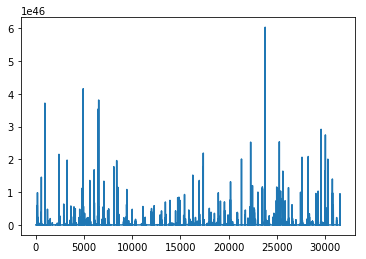

In [65]:
# 正常音のスコアをプロット
plt.plot(np.exp(-scores_fastdstd))

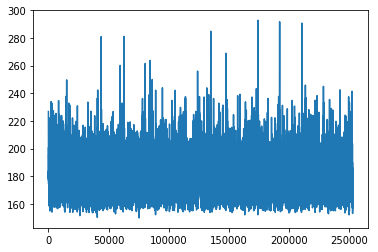

In [64]:
# 正常音のスコアをプロット
plt.plot(-scores_mfcc64)

In [56]:
scores_anom_fastdstd =(-gmm_fastdstd.score_samples(anom_test_0db_fastdstd_drop))
scores_norm_fastdstd =(-gmm_fastdstd.score_samples(norm_test_0db_fastdstd_drop))

scores_anom_mfcc64   =(-gmm_mfcc64.score_samples(anom_test_0db_mfcc64_drop))
scores_norm_mfcc64   =(-gmm_mfcc64.score_samples(norm_test_0db_mfcc64_drop))

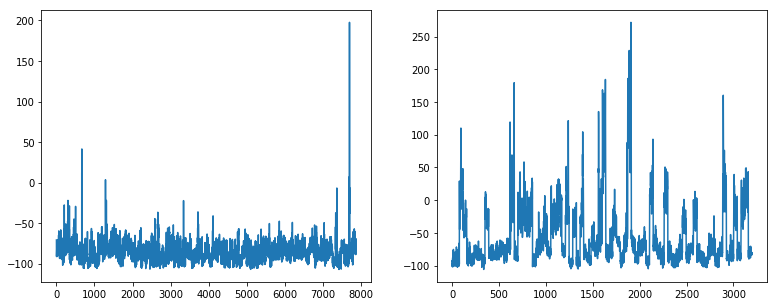

In [57]:
# fastdstdのスコアをプロット
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(scores_norm_fastdstd)
plt.subplot(1,2,2)
plt.plot(scores_anom_fastdstd)


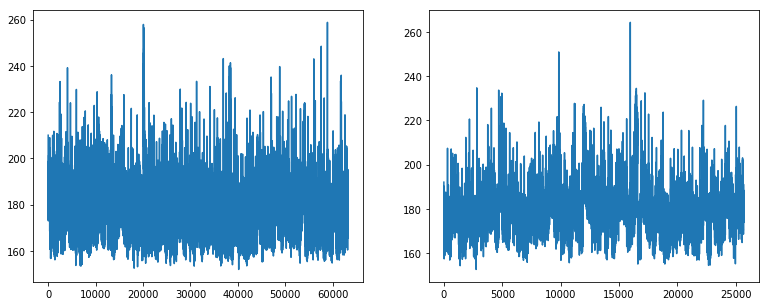

In [58]:
# mfcc64のスコアをプロット
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(scores_norm_mfcc64)
plt.subplot(1,2,2)
plt.plot(scores_anom_mfcc64)


In [17]:
class autoencoder(nn.Module):
    def __init__(self, feature_dim, hidden_dim, latent_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, feature_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# MyDataSetの作成
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = np.array(data)
        self.data_num = len(data)
        
        
        
    def __len__(self):
        return self.data_num
        
    def __getitem__(self, idx):
        out_data = self.data[idx]
        
        if self.transform:
            out_data = self.transform(out_data)
        return out_data

## FastD standard の特徴量を学習

In [20]:
# MyDataSetの作成
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = np.array(data)
        self.data_num = len(data)
        
        
        
    def __len__(self):
        return self.data_num
        
    def __getitem__(self, idx):
        out_data = self.data[idx]
        
        if self.transform:
            out_data = self.transform(out_data)
        return out_data

In [21]:
# transform = transforms.Compose([transforms.ToTensor()])
data_set = norm_train_0db_fastdstd_drop
train_dataset = MyDataset(data_set)

In [22]:
# データセットをデータローダーに変換
train_batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [23]:
# モデルのインスタンス化
model_fastdstd = autoencoder(feature_dim=feature_dim_fastdstd, hidden_dim=hidden_dim_fastdstd, latent_dim=latent_dim_fastdstd).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model_fastdstd.parameters(), lr=learning_rate, weight_decay=1e-5)


In [24]:
model_fastdstd

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=34, out_features=6, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=6, out_features=3, bias=True)
    (5): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=6, out_features=34, bias=True)
  )
)

In [25]:
# モデルの学習
model_fastdstd.train()
loss_list_fastdstd = []

for epoch in progress_bar(range(num_epochs)):
    losses_fastdstd = []
    
    for x in train_loader:
        x = x.to(device)
#         print(x.shape)
        model_fastdstd.zero_grad()
        xhat = model_fastdstd(x.float())
        loss = criterion(xhat.float(), x.float())
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_fastdstd.append(loss.cpu().detach().numpy())
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch + 1, num_epochs, np.average(losses_fastdstd))) 
#     scheduler.step()
    loss_list_fastdstd.append(np.average(losses_fastdstd))

epoch [1/50], loss: 13.0016
epoch [2/50], loss: 12.5092
epoch [3/50], loss: 10.8582
epoch [4/50], loss: 6.5630
epoch [5/50], loss: 1.7235
epoch [6/50], loss: 0.1067
epoch [7/50], loss: 0.0173
epoch [8/50], loss: 0.0165
epoch [9/50], loss: 0.0164
epoch [10/50], loss: 0.0164
epoch [11/50], loss: 0.0163
epoch [12/50], loss: 0.0163
epoch [13/50], loss: 0.0162
epoch [14/50], loss: 0.0161
epoch [15/50], loss: 0.0161
epoch [16/50], loss: 0.0160
epoch [17/50], loss: 0.0159
epoch [18/50], loss: 0.0159
epoch [19/50], loss: 0.0158
epoch [20/50], loss: 0.0157
epoch [21/50], loss: 0.0157
epoch [22/50], loss: 0.0156
epoch [23/50], loss: 0.0155
epoch [24/50], loss: 0.0154
epoch [25/50], loss: 0.0154
epoch [26/50], loss: 0.0153
epoch [27/50], loss: 0.0152
epoch [28/50], loss: 0.0152
epoch [29/50], loss: 0.0151
epoch [30/50], loss: 0.0151
epoch [31/50], loss: 0.0150
epoch [32/50], loss: 0.0150
epoch [33/50], loss: 0.0149
epoch [34/50], loss: 0.0149
epoch [35/50], loss: 0.0149
epoch [36/50], loss: 0.014

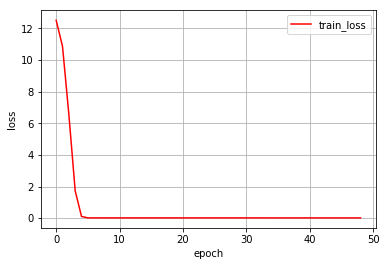

In [26]:
plt.figure()
plt.plot(range(epoch), loss_list_fastdstd[1:], 'r-', label = 'train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

## mfcc64の特徴量で学習

In [27]:
# transform = transforms.Compose([transforms.ToTensor()])
data_set = norm_train_0db_mfcc64_drop
train_dataset = MyDataset(data_set)

In [28]:
len(train_dataset)

253217

In [29]:
# データセットをデータローダーに変換
train_batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [30]:
# モデルのインスタンス化
model_mfcc64 = autoencoder(feature_dim=feature_dim_mfcc64, hidden_dim=hidden_dim_mfcc64, latent_dim=latent_dim_mfcc64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model_mfcc64.parameters(), lr=learning_rate, weight_decay=1e-5)


In [31]:
model_mfcc64

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=12, out_features=3, bias=True)
    (5): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=12, out_features=64, bias=True)
  )
)

In [42]:
# モデルの学習
model_mfcc64.train()
loss_list_mfcc64 = []

for epoch in progress_bar(range(num_epochs)):
    losses_mfcc64 = []
    
    for x in train_loader:
        x = x.to(device)
#         print(x.shape)
        model_mfcc64.zero_grad()
        xhat = model_mfcc64(x.float())
        loss = criterion(xhat.float(), x.float())
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_mfcc64.append(loss.cpu().detach().numpy())
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch + 1, num_epochs, np.average(losses_mfcc64))) 
#     scheduler.step()
    loss_list_mfcc64.append(np.average(losses_mfcc64))

epoch [1/50], loss: 19.9096
epoch [2/50], loss: 19.9094
epoch [3/50], loss: 19.9072
epoch [4/50], loss: 19.9102
epoch [5/50], loss: 19.9086
epoch [6/50], loss: 19.9071
epoch [7/50], loss: 19.9071
epoch [8/50], loss: 19.9060
epoch [9/50], loss: 19.9026
epoch [10/50], loss: 19.9050
epoch [11/50], loss: 19.9048
epoch [12/50], loss: 19.9037
epoch [13/50], loss: 19.9044
epoch [14/50], loss: 19.9068
epoch [15/50], loss: 19.9038
epoch [16/50], loss: 19.9027
epoch [17/50], loss: 19.9042
epoch [18/50], loss: 19.9002
epoch [19/50], loss: 19.9025
epoch [20/50], loss: 19.8997
epoch [21/50], loss: 19.9020
epoch [22/50], loss: 19.9007
epoch [23/50], loss: 19.8991
epoch [24/50], loss: 19.9003
epoch [25/50], loss: 19.8976
epoch [26/50], loss: 19.8953
epoch [27/50], loss: 19.8969
epoch [28/50], loss: 19.8950
epoch [29/50], loss: 19.8951
epoch [30/50], loss: 19.8955
epoch [31/50], loss: 19.8930
epoch [32/50], loss: 19.8932
epoch [33/50], loss: 19.8925
epoch [34/50], loss: 19.8934
epoch [35/50], loss: 19

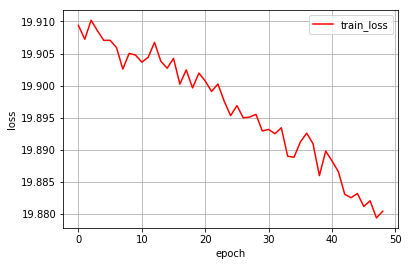

In [43]:
plt.figure()
plt.plot(range(epoch), loss_list_mfcc64[1:], 'r-', label = 'train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(epoch), loss_list_fastdstd[1:], 'r-', label = 'train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

評価用のデータセット
- fastd-std  
norm_test_0db_fastdstd_drop  
anom_test_0db_fastdstd_drop  

- mfcc64  
norm_test_0db_mfcc64_drop  
anom_test_0db_mfcc64_drop  

# Predict

In [44]:
# MyDataSetの作成
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = np.array(data)
        self.data_num = len(data)
        
        
        
    def __len__(self):
        return self.data_num
        
    def __getitem__(self, idx):
        out_data = self.data[idx]
        
        if self.transform:
            out_data = self.transform(out_data)
        return out_data

In [45]:
# transform = transforms.Compose([transforms.ToTensor()])
test_norm_dataset_fastdstd = MyDataset(norm_test_0db_fastdstd_drop)
test_anom_dataset_fastdstd = MyDataset(anom_test_0db_fastdstd_drop)

test_norm_dataset_mfcc64   = MyDataset(norm_test_0db_mfcc64_drop)
test_anom_dataset_mfcc64   = MyDataset(anom_test_0db_mfcc64_drop)

In [46]:
# データセットをデータローダーに変換
test_batch_size = 1

test_norm_loader_fastdstd = DataLoader(test_norm_dataset_fastdstd, batch_size=test_batch_size, shuffle=False)
test_anom_loader_fastdstd = DataLoader(test_anom_dataset_fastdstd, batch_size=test_batch_size, shuffle=False)

test_norm_loader_mfcc64   = DataLoader(test_norm_dataset_mfcc64  , batch_size=test_batch_size, shuffle=False)
test_anom_loader_mfcc64   = DataLoader(test_anom_dataset_mfcc64  , batch_size=test_batch_size, shuffle=False)

In [47]:
vars(model_fastdstd.state_dict())

{'_metadata': OrderedDict([('', {'version': 1}),
              ('encoder', {'version': 1}),
              ('encoder.0', {'version': 1}),
              ('encoder.1', {'version': 1}),
              ('encoder.2', {'version': 1}),
              ('encoder.3', {'version': 1}),
              ('encoder.4', {'version': 1}),
              ('encoder.5', {'version': 1}),
              ('decoder', {'version': 1}),
              ('decoder.0', {'version': 1}),
              ('decoder.1', {'version': 1}),
              ('decoder.2', {'version': 1}),
              ('decoder.3', {'version': 1}),
              ('decoder.4', {'version': 1})])}

## FASTD standardの特徴量のテスト

In [48]:
# fastdstd テスト開始
model_fastdstd = model_fastdstd.to(device)
model_fastdstd.eval()


# 正常データテスト
losses_norm_fastdstd = []
count=0
for x in test_norm_loader_fastdstd:
    x = x.to(device)
    xhat = model_fastdstd(x.float())
    loss_norm = criterion(xhat.float(), x.float())
    losses_norm_fastdstd.append(loss_norm.cpu().detach().numpy())
    sys.stdout.write("\r%s" % "現在"+str(np.around((count/len(test_norm_loader_fastdstd))*100 , 2))+"%完了")
    sys.stdout.flush()
    count += 1
    
# 異常データテスト
losses_anom_fastdstd = []
count=0
for x in test_anom_loader_fastdstd:
    x = x.to(device)
    xhat = model_fastdstd(x.float())
    loss_anom = criterion(xhat.float(), x.float())
    losses_anom_fastdstd.append(loss_anom.cpu().detach().numpy())
    sys.stdout.write("\r%s" % "現在"+str(np.around((count/len(test_anom_loader_fastdstd))*100 , 2))+"%完了")
    sys.stdout.flush()
    count += 1



現在17.01%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在99.97%完了

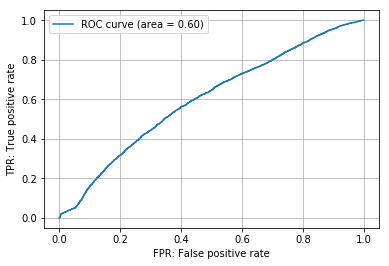

In [49]:
# ROC曲線の描写

y_true  = np.concatenate([np.zeros(len(test_norm_dataset_fastdstd)),np.ones(len(test_anom_dataset_fastdstd))])
y_score = np.concatenate([losses_norm_fastdstd, losses_anom_fastdstd])

fpr, tpr, thresholds = roc_curve(y_true, y_score)
fpr = np.array(fpr, dtype='float16')
tpr = np.array(tpr, dtype='float16')
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig("./{}/{}".format(out_figs_dir, name_roc))
# plt.close()


## mfcc64の特徴量のテスト

In [50]:
# mfcc64 テスト開始
model_mfcc64 = model_mfcc64.to(device)
model_mfcc64.eval()


# 正常データテスト
losses_norm_mfcc64 = []
count=0
for x in test_norm_loader_mfcc64:
    x = x.to(device)
    xhat = model_mfcc64(x.float())
    loss_norm = criterion(xhat.float(), x.float())
    losses_norm_mfcc64.append(loss_norm.cpu().detach().numpy())
    sys.stdout.write("\r%s" % "現在"+str(np.around((count/len(test_norm_loader_mfcc64))*100 , 2))+"%完了")
    sys.stdout.flush()
    count += 1
    
# 異常データテスト
losses_anom_mfcc64 = []
count=0
for x in test_anom_loader_mfcc64:
    x = x.to(device)
    xhat = model_mfcc64(x.float())
    loss_anom = criterion(xhat.float(), x.float())
    losses_anom_mfcc64.append(loss_anom.cpu().detach().numpy())
    sys.stdout.write("\r%s" % "現在"+str(np.around((count/len(test_anom_loader_mfcc64))*100 , 2))+"%完了")
    sys.stdout.flush()
    count += 1



現在16.34%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在22.27%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在38.33%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在44.5%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在29.07%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在48.55%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在63.06%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在78.23%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在93.31%完了

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



現在100.0%完了

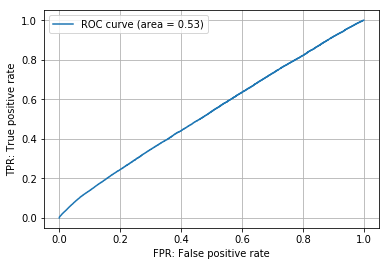

In [51]:
# ROC曲線の描写

y_true  = np.concatenate([np.zeros(len(test_norm_dataset_mfcc64)),np.ones(len(test_anom_dataset_mfcc64))])
y_score = np.concatenate([losses_norm_mfcc64, losses_anom_mfcc64])

fpr, tpr, thresholds = roc_curve(y_true, y_score)
fpr = np.array(fpr, dtype='float16')
tpr = np.array(tpr, dtype='float16')
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig("./{}/{}".format(out_figs_dir, name_roc))
# plt.close()
